# Setup

In [128]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.ndimage import rotate

In [129]:
horizontal_Prewitt = np.array([
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1],
])

horizontal_Sobel = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1],
])

vertical_Prewitt = np.array([
    [-1, -1, -1],
    [0, 0, 0],
    [1, 1, 1],
])

vertical_Sobel = np.array([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1],
])
#https://stackoverflow.com/questions/63036809/how-do-i-use-only-numpy-to-apply-filters-onto-images
def convolve(image, filter, padding = (1, 1)):
    if(image.ndim == 2):
        image = np.expand_dims(image, axis=-1) 
    if(filter.ndim == 2):
        filter = np.repeat(np.expand_dims(filter, axis=-1), image.shape[-1], axis=-1)
    if(filter.shape[-1] == 1):
        filter = np.repeat(filter, image.shape[-1], axis=-1) 
    assert image.shape[-1] == filter.shape[-1]
    size_x, size_y = filter.shape[:2]
    width, height = image.shape[:2]
    
    output_array = np.zeros(((width - size_x + 2*padding[0]) + 1, 
                             (height - size_y + 2*padding[1]) + 1,
                             image.shape[-1])) 
    
    padded_image = np.pad(image, [
        (padding[0], padding[0]),
        (padding[1], padding[1]),
        (0, 0)
    ])
    
    for x in range(padded_image.shape[0] - size_x + 1):
        for y in range(padded_image.shape[1] - size_y + 1):
            window = padded_image[x:x + size_x, y:y + size_y]
            output_values = np.sum(filter * window, axis=(0, 1)) 
            output_array[x, y] = output_values
            
    return output_array

In [130]:
def psnr(original, noisy):
    """
    Calculating Peak signal to noise ratio.

    ----------
    parameters:
        original : numpy 2D array, representing a original image.
        noisy : numpy 2D array, representing a noisy image.
    
    return:
        PSNR value
    """
    mse = np.mean((original - noisy) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    psnr_value = 20 * math.log10(PIXEL_MAX / math.sqrt(mse))
    return psnr_value

In [131]:
#https://scipy-lectures.org/intro/scipy/auto_examples/solutions/plot_fft_image_denoise.html

def plot_spectrum(im_fft):
    from matplotlib.colors import LogNorm
    plt.imshow(np.abs(im_fft), norm=LogNorm(vmin=5))
    plt.colorbar()

def denoise_image(image,keep_fraction):

    denoised = image.copy()
    
    denoised = np.fft.fft2(denoised)
    # keep_fraction = 0.134100000000001
    im_fft2 = denoised.copy()
    r, c = im_fft2.shape
    im_fft2[int(r*keep_fraction):int(r*(1-keep_fraction))] = 0
    im_fft2[:, int(c*keep_fraction):int(c*(1-keep_fraction))] = 0

    from matplotlib.colors import LogNorm
    plt.imshow(np.abs(np.fft.ifft2(im_fft2).real), norm=LogNorm(vmin=5),cmap='gray')

    return np.fft.ifft2(im_fft2).real

In [132]:
list = np.array([])
# list[list < 255] = 100
# print(list)

In [133]:
def hist_equ(image):

    size = image.shape[0:2]
    image_size = size[0]*size[1]
    L = 256

    unique, counts = np.unique(image, return_counts=True)
    pxl_count = dict(zip(unique, counts))

    key = [*pxl_count]
    key.sort() # we can remove this line
    list_sum = [] # sigma (𝑛𝑗 / 𝑛)
    counter = 0

    new_pxl = {}
    
    for item in key:
        counter += pxl_count[item]
        new_pxl.update({item:int((counter/image_size) * (L-1))})


    # print(len(image[0]))
    for row in range(size[0]):
        for col in range(size[1]):
            image[row][col] = new_pxl[image[row][col]]

    return image

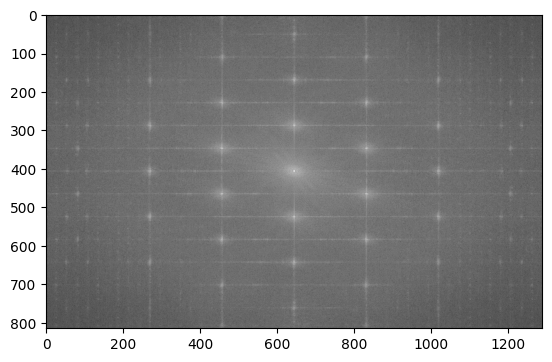

In [134]:
image = cv2.imread("images/img_01.jpg",0) 
denoised = image.copy()
    
denoised = np.fft.fft2(denoised)
im_fft2 = denoised.copy()
r, c = im_fft2.shape

# plt.imshow(np.abs(np.fft.ifft2(im_fft2).real), norm=LogNorm(vmin=5),cmap='gray')

for x in range(im_fft2.shape[0]):
    im_fft2[x] = np.roll(im_fft2[x], int(im_fft2.shape[1]/2))
im_fft2 = rotate(im_fft2, angle=90)

for x in range(im_fft2.shape[0]):
    im_fft2[x] = np.roll(im_fft2[x], int(im_fft2.shape[1]/2))
im_fft2 = rotate(im_fft2, angle=-90)


plt.imshow(np.abs(im_fft2), norm=LogNorm(vmin=5),cmap='gray')
equ_cv = np.abs(im_fft2)
# equ_cv_show = equ_cv.copy()
# plt.imshow(hist_equ(equ_cv_show),cmap='gray')


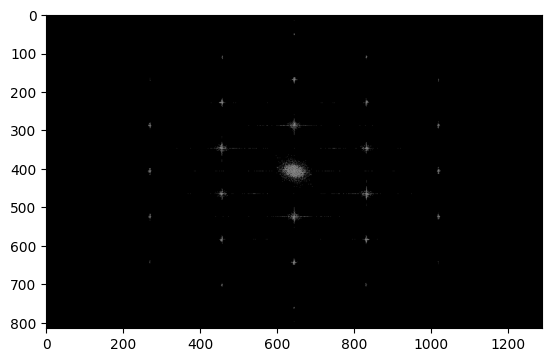

In [135]:
equ_cv_new = equ_cv.copy()
im_fft2_new = im_fft2.copy()

x_,y_ = equ_cv_new.shape
max = np.max(equ_cv)*0.0006
for x in range(x_):
    for y in range(y_):
        if equ_cv_new[x,y] > max:
            equ_cv_new[x,y] = 0
            im_fft2_new[x,y] = 0

im_fft2_hold = im_fft2 - im_fft2_new
equ_cv_hold = equ_cv - equ_cv_new

equ_cv_show = equ_cv_hold.copy()
plt.imshow(hist_equ(equ_cv_show),cmap='gray')

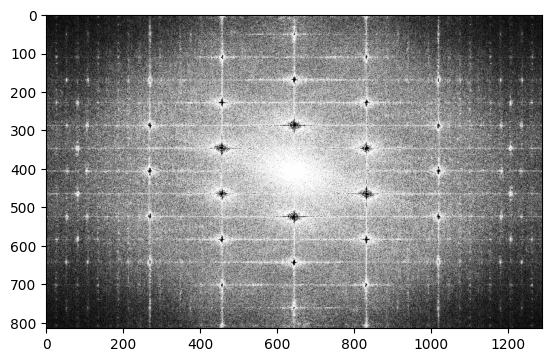

In [136]:
equ_cv_1 = equ_cv.copy()
im_fft2_1= im_fft2.copy()

for x in range(x_):
    for y in range(y_):
        # if(not(not(x < 320 or x > 500) and not(y>770 or  y<520))):
        if(math.sqrt((x - (500 - (500-320)/2)) ** 2 + (y - (770-(770-520)/2)) ** 2) > 100):
            equ_cv_1[x,y] = equ_cv_1[x,y] - equ_cv_hold[x,y]
            im_fft2_1[x,y] = im_fft2_1[x,y] - im_fft2_hold[x,y]

equ_cv_show = equ_cv_1.copy()
plt.imshow(hist_equ(equ_cv_show),cmap='gray')

In [137]:
for x in range(equ_cv_1.shape[0]):
    equ_cv_1[x] = np.roll(equ_cv_1[x], -int(equ_cv_1.shape[1]/2))
equ_cv_1 = rotate(equ_cv_1, angle=90)
for x in range(equ_cv_1.shape[0]):
    equ_cv_1[x] = np.roll(equ_cv_1[x], -int(equ_cv_1.shape[1]/2))
equ_cv_1 = rotate(equ_cv_1, angle=-90)


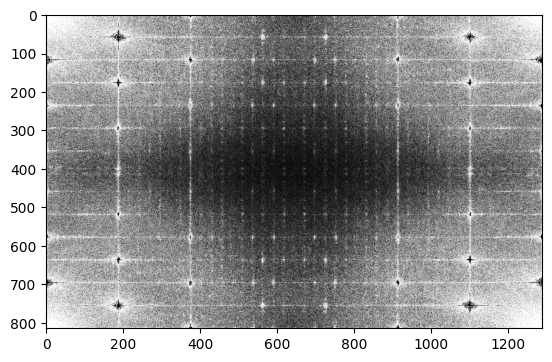

In [138]:
equ_cv_show = equ_cv_1.copy()
plt.imshow(hist_equ(equ_cv_show),cmap='gray')

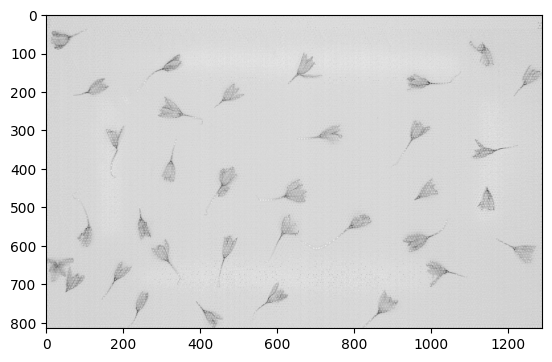

In [139]:
____a = im_fft2_1.copy()
for x in range(____a.shape[0]):
    ____a[x] = np.roll(____a[x], -int(____a.shape[1]/2))
____a = rotate(____a, angle=90)
for x in range(____a.shape[0]):
    ____a[x] = np.roll(____a[x], -int(____a.shape[1]/2))
____a = rotate(____a, angle=-90)


_best = np.abs(np.fft.ifft2(____a).real)
plt.imshow(_best, norm=LogNorm(vmin=5),cmap='gray')

In [140]:
def f(x,y):
  return np.sin((1/2)*np.pi*x)+np.cos((1/3)*np.pi*y)

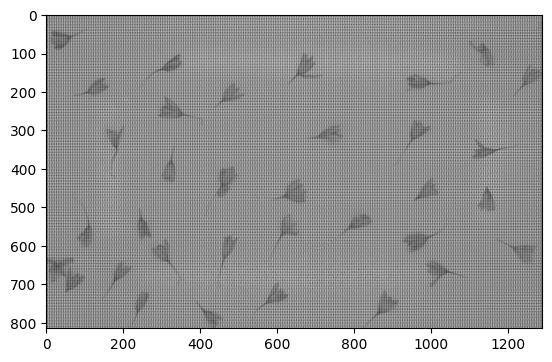

PSNR between noisy image and original image =  8.133468809633587
PSNR between denoised image and original image =  23.96944916803777
PSNR between denoised image(_best) and original image =  17.46489070819888


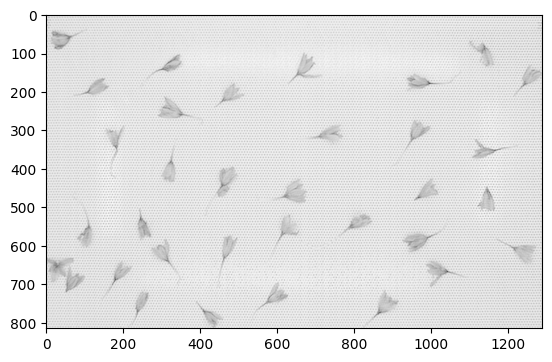

In [141]:
original_image = cv2.imread("images/img_01.jpg",0)

X,Y = original_image.shape
noise = np.zeros((X,Y))
for i in range(X):
  for j in range(Y):
    noise[i,j] = f(i,j)*100

noisy_image = original_image + noise

plt.imshow(noisy_image,cmap='gray')
plt.show()

hold = 0
hold_i = 0
for i in np.arange(0.1, 0.2, 0.001):
  denoised_image = denoise_image(noisy_image,i)
  hold_psnr = psnr(original_image,denoised_image)
  if hold_psnr > hold :
    hold = hold_psnr
    hold_i = i
denoised_image = denoise_image(noisy_image,hold_i)
print("PSNR between noisy image and original image = ",
      psnr(original_image,noisy_image))
print("PSNR between denoised image and original image = ",
      psnr(original_image,denoised_image))
print("PSNR between denoised image(_best) and original image = ",
      psnr(original_image,_best))
  


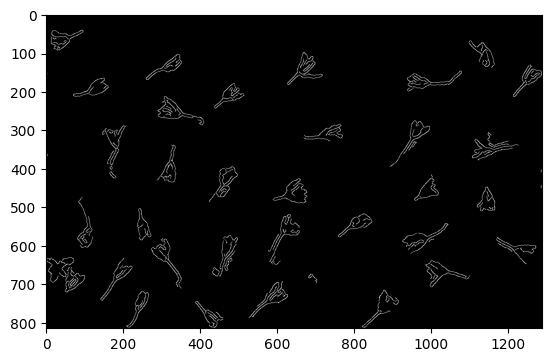

In [142]:
denoised_image = denoise_image(noisy_image,0.1)
img_blur = cv2.GaussianBlur(denoised_image, (3,3), 0) 
list_row = []

for row in range(img_blur.shape[0]):
    list_col = []
    for col in range(img_blur.shape[1]):
        list_col.append(img_blur[row,col].astype(np.uint8))
    list_row.append(list_col)
    

canny = cv2.Canny(np.array(list_row),90,20)

plt.imshow(canny,cmap='gray')
plt.show()


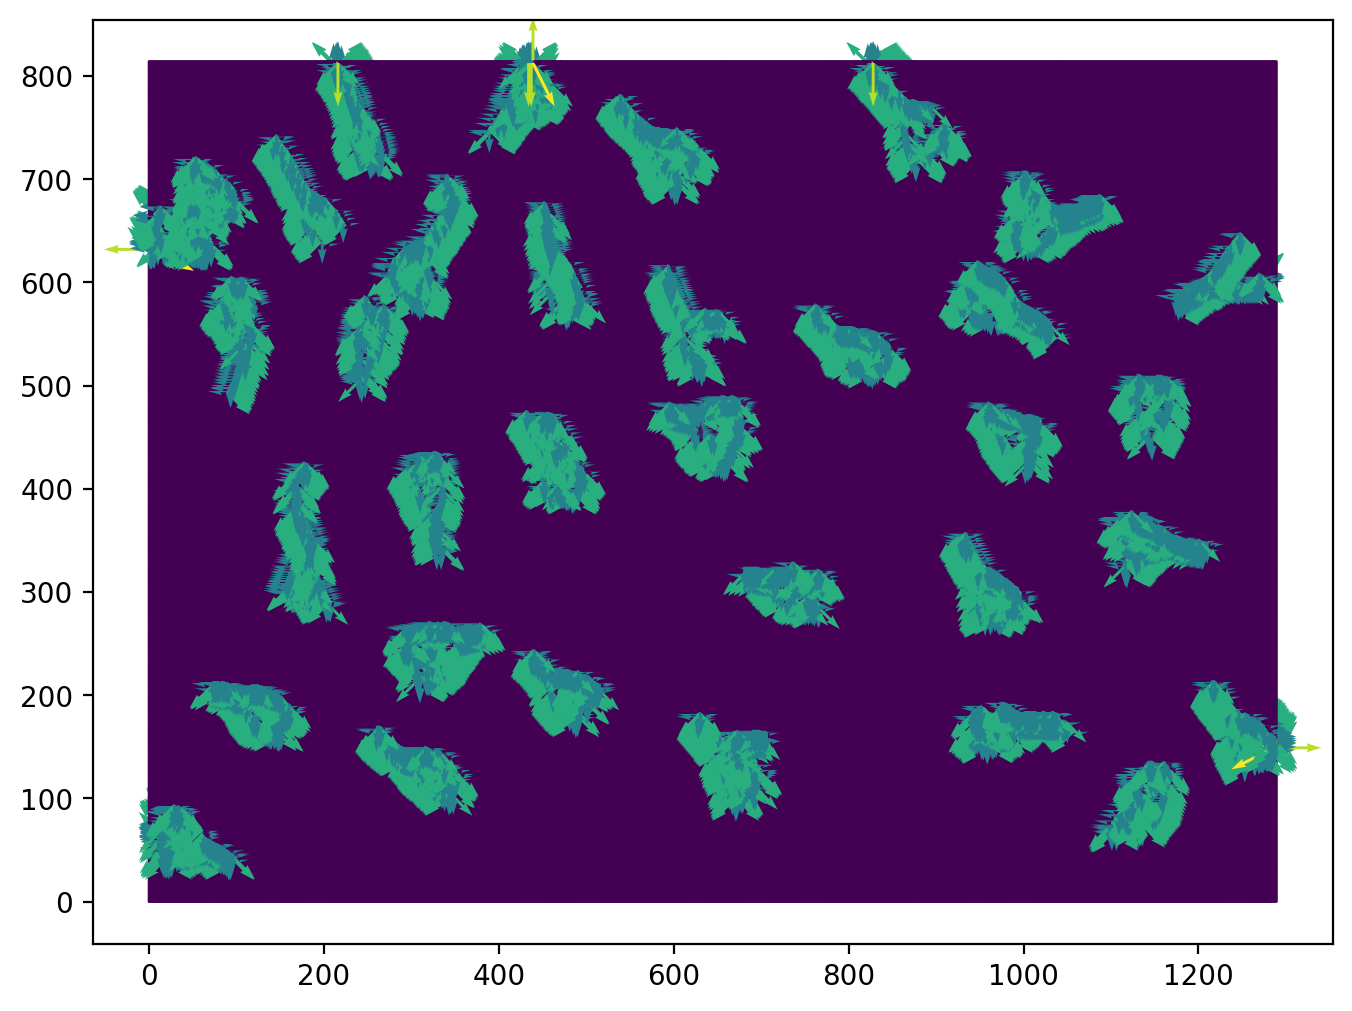

In [161]:
#https://stackoverflow.com/questions/59631756/gradient-orientation-with-arctan2-results-in-flipped-angles
canny = cv2.Canny(np.array(list_row),120,50)
from matplotlib.pyplot import figure
dy,dx = np.gradient(canny)
theta =np.degrees(np.arctan2(dy,dx))
color = np.sqrt(dy**2 + dx**2) 
figure(figsize=(8, 6), dpi=200)
# color = rotate(color, angle=180)
plt.quiver(dx,dy,color)
plt.show()

In [ ]:
g_x = convolve(canny, horizontal_Sobel)
g_y = convolve(canny, vertical_Sobel)


list_row = []
for x in range(g_x.shape[0]):
    list_col = []
    for y in range(g_x.shape[1]):
        list_col.append(np.arctan2(g_y[x,y], g_x[x,y]))
    list_row.append(list_col)

# plt.quiver(dx,dy,color)
# plt.show()

# Q2

In [115]:
list_x = []
for x in range(32):
    list_y = []
    for y in range(32):
        list_y.append(0)
    list_x.append(list_y)

img = np.array(list_x)
img[31,3] = 255


Text(0.5, 1.0, 'real')

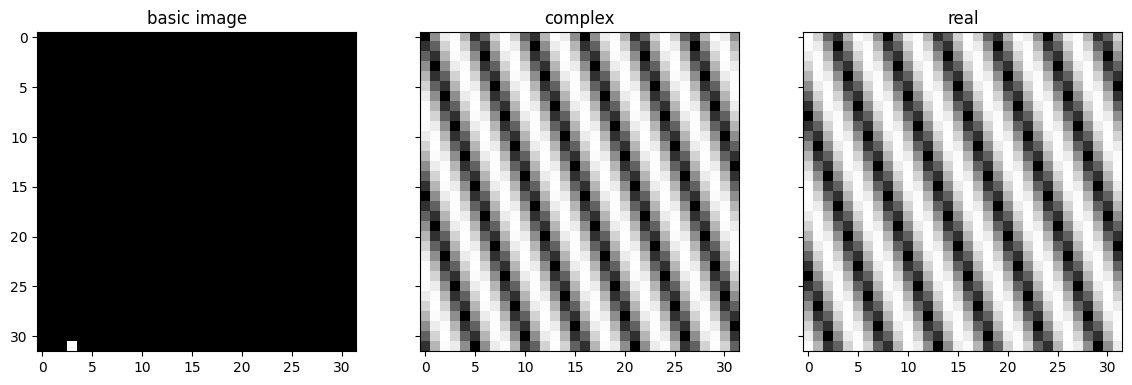

In [116]:
denoised = np.fft.fft2(img)
hold1 = denoised.copy()

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(14, 14),
                                    sharex=True, sharey=True)

ax1.imshow(img,cmap='gray')
ax1.set_title('basic image')
ax2.imshow(np.abs(hold1-hold1.real),cmap='gray')
ax2.set_title('complex')
ax3.imshow(np.abs(hold1.real),cmap='gray')
ax3.set_title('real')

Text(0.5, 1.0, 'real')

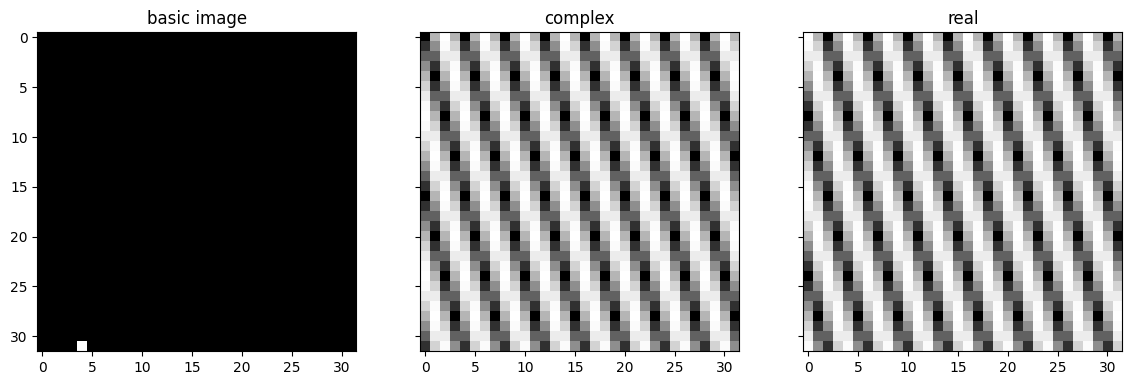

In [117]:
img[31,3] = 0
img[31,4] = 255

denoised = np.fft.fft2(img)
hold2 = denoised.copy()

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(14, 14),
                                    sharex=True, sharey=True)

ax1.imshow(img,cmap='gray')
ax1.set_title('basic image')
ax2.imshow(np.abs(hold2-hold2.real),cmap='gray')
ax2.set_title('complex')
ax3.imshow(np.abs(hold2.real),cmap='gray')
ax3.set_title('real')

Text(0.5, 1.0, 'complex')

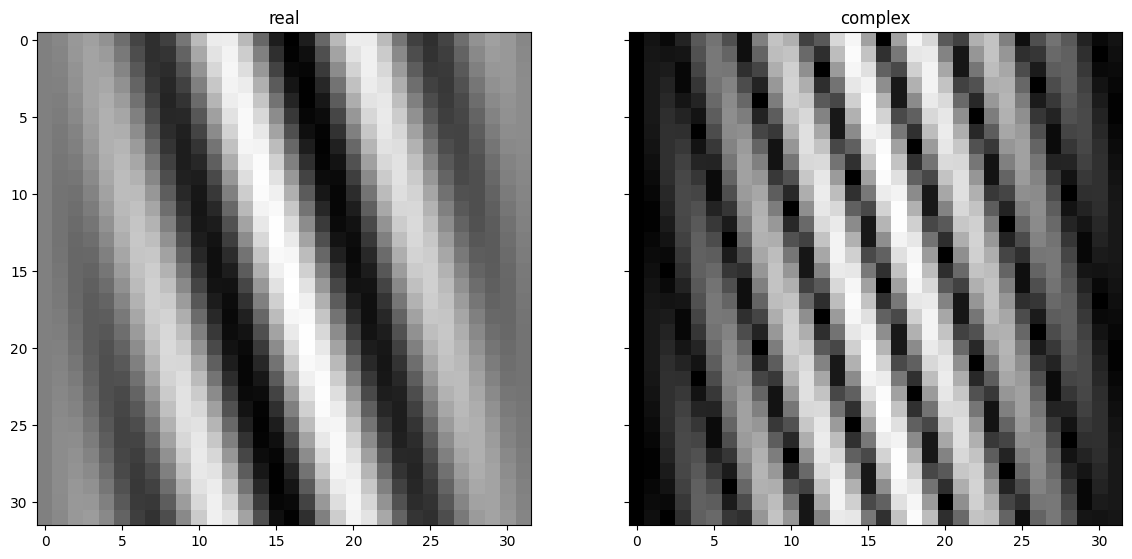

In [126]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 14),
                                    sharex=True, sharey=True)

ax1.imshow((hold1-hold2).real,cmap='gray')
ax1.set_title('real')
ax2.imshow(np.abs((hold1-hold1.real)-(hold2-hold2.real)),cmap='gray')
ax2.set_title('complex')


# Q3

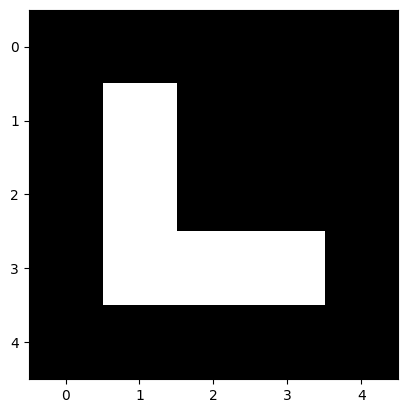

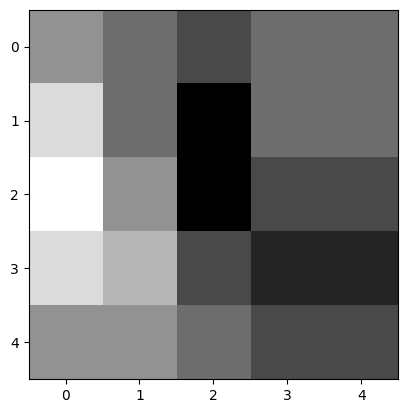

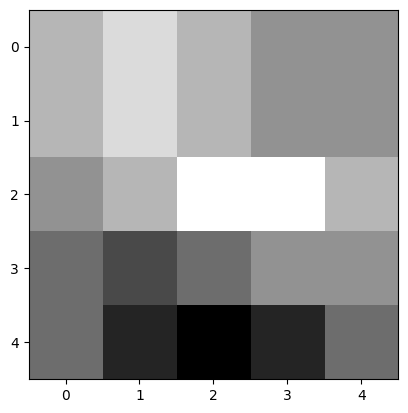

<Figure size 360x480 with 0 Axes>

<Figure size 360x480 with 0 Axes>

In [20]:
fiveXfive = np.array([
    [0, 0, 0, 0, 0],
    [0, 250, 0, 0, 0],
    [0, 250, 0, 0, 0],
    [0, 250, 250, 250, 0],
    [0, 0, 0, 0, 0],
])

plt.imshow(fiveXfive,cmap='gray')
plt.show()

g_y = convolve(fiveXfive, vertical_Sobel)
g_x = convolve(fiveXfive, horizontal_Sobel)

plt.imshow(g_x,cmap='gray')
plt.show()
plt.imshow(g_y,cmap='gray')
plt.show()


theta =np.degrees(np.arctan2(g_y,g_x))
color = np.sqrt(g_y**2 + g_x**2) 
figure(figsize=(3, 4), dpi=120)


# Q4

In [21]:
#https://stackoverflow.com/questions/41329665/linesegmentdetector-in-opencv-3-with-python
from numpy import ones,vstack
from numpy.linalg import lstsq

img = cv2.imread("images/img_02.jpg",0)
lsd = cv2.createLineSegmentDetector(0)
dlines = lsd.detect(img)
for dline in dlines[0]:
    x0 = int(round(dline[0][0]))
    y0 = int(round(dline[0][1]))
    x1 = int(round(dline[0][2]))
    y1 = int(round(dline[0][3]))


points = [(x0,y0),(x1,y1)]
x_coords, y_coords = zip(*points)
A = vstack([x_coords,ones(len(x_coords))]).T
m, c = lstsq(A, y_coords)[0]
print("Line Solution is y = {m}x + {c}".format(m=m,c=c))

Line Solution is y = 0.7317073170731702x + 151.24390243902445


C:\Users\mousa\AppData\Local\Temp\ipykernel_13704\2592067524.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = lstsq(A, y_coords)[0]
